# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [ ]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [ ]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### FSC

In [ ]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

In [ ]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

In [ ]:
plt.plot(res, fsc)

In [ ]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [ ]:
fsc

In [ ]:
fsc[10]

In [ ]:
fsc[11]

In [ ]:
res_angs[10]

In [ ]:
res_angs[11]

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

#### CG

#### Newton's method

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [3]:
n = 1000

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

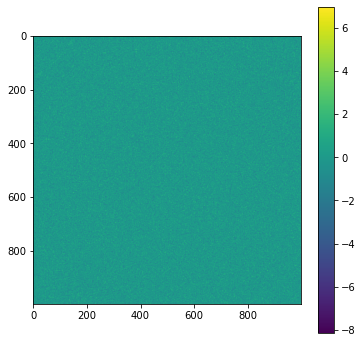

In [4]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [5]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [6]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [7]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [8]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

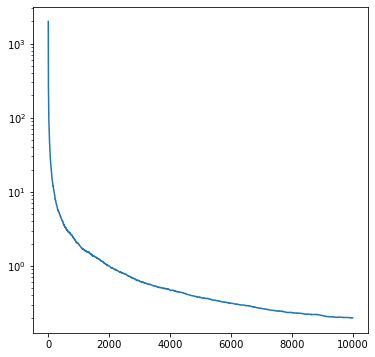

In [9]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [10]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [168]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [169]:
f(x0)

DeviceArray(0., dtype=float64)

In [13]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [16]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

0.009347677230834961
0.005343437194824219


DeviceArray(0., dtype=float64)

#### Toy problem

In [170]:
key, subkey = random.split(key)

sig_noise = 0.01
x = x0

A = A.at[0,0].set(100)
b = A @ x + random.normal(subkey, (n,)) * sig_noise
f = lambda x : jnp.mean((A @ x - b)**2)
print(f"f(x0) = {f(x)}")

f(x0) = 9.557846448153806e-05


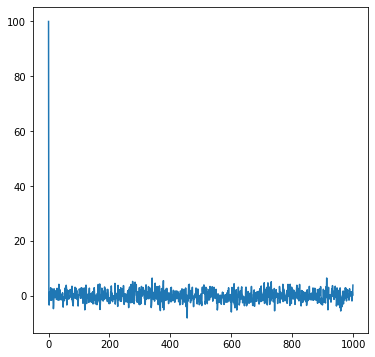

In [171]:
plt.plot(jnp.diag(A))

In [172]:
def gd(F, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jax.grad(F)(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = jax.grad(F)(w0)
        H = jax.hessian(F)(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [174]:
N_iter = 5000
eta = 0.01 # learning rate
x0 = np.random.randn(*x0.shape)

x_gd, loss_gd = gd(f, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 17.936667480947975
Iter 400: loss = 6.133951721518374
Iter 600: loss = 3.3882320586231383
Iter 800: loss = 2.266772381876651
Iter 1000: loss = 1.6688146424612242
Iter 1200: loss = 1.30151780872569
Iter 1400: loss = 1.0555023766247147
Iter 1600: loss = 0.8805228007302419
Iter 1800: loss = 0.7503416665575087
Iter 2000: loss = 0.6500301307176332
Iter 2200: loss = 0.5705385127536288
Iter 2400: loss = 0.5060979677090007
Iter 2600: loss = 0.45287421650186827
Iter 2800: loss = 0.40822676519369394
Iter 3000: loss = 0.3702809612049233
Iter 3200: loss = 0.33767034758087244
Iter 3400: loss = 0.3093758487118103
Iter 3600: loss = 0.2846221331781394
Iter 3800: loss = 0.26280888987162326
Iter 4000: loss = 0.24346407569408685
Iter 4200: loss = 0.22621137324968627
Iter 4400: loss = 0.2107470693879177
Iter 4600: loss = 0.19682332163264812
Iter 4800: loss = 0.18423584531775777
Iter 5000: loss = 0.1728147172608635


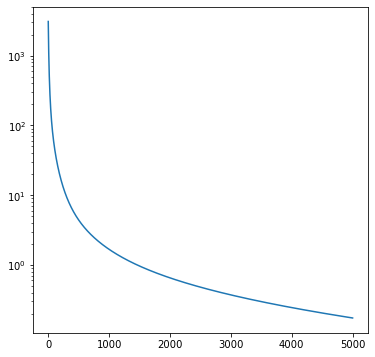

In [175]:
plt.semilogy(loss_gd)

In [176]:
N_iter = 10

x_n, loss_n = newton(f, x0, N_iter, iter_display = 1)

Iter 1: loss = 1.1946203331967342e-16
Iter 2: loss = 1.523288821496982e-28
Iter 3: loss = 1.3696088563986138e-28
Iter 4: loss = 1.4249025824358833e-28
Iter 5: loss = 1.6815695713060192e-28
Iter 6: loss = 1.4406105286920638e-28
Iter 7: loss = 1.41679555752054e-28
Iter 8: loss = 1.5257308390367069e-28
Iter 9: loss = 1.5768667750653959e-28
Iter 10: loss = 1.5120357206840043e-28


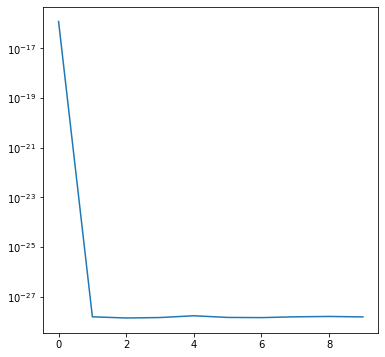

In [177]:
plt.semilogy(loss_n)

#### OASIS with fixed learning rate

In [187]:
# First attempt

def oasis(key, F, w0, eta, D0, beta2, alpha, N_iter = 20, iter_display = 1):
    z = random.rademacher(key, (iters, n)).astype(jnp.float64)
    
    Dhat0 = jnp.diag(jnp.maximum(jnp.diag(D0), alpha))
                        
    invDhat0 = jnp.diag(1/jnp.diag(Dhat0))
    w1 = w0 - eta * (invDhat0 @ jax.grad(F)(w0))

    loss = []
    for k in range(1, N_iter+1):

        D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvp(F, (w1,), (z[k-1],)))
        Dhat1 = jnp.diag(jnp.maximum(jnp.abs(jnp.diag(D1)), alpha))

        invDhat1 = jnp.diag(1/jnp.diag(Dhat1))
        
        w2 = w1 - eta * (invDhat1 @ jax.grad(F)(w1))
        
        w0 = w1
        w1 = w2

        loss_i = F(w1)
        loss.append(loss_i)        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
    return w1, jnp.array(loss)

In [189]:
N_iter = 5000
beta2 = 0.99
eta = 0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(jnp.diag(jax.hessian(f)(x0))) # Cheating a bit
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, f, x0, eta, D0, beta2, alpha, N_iter, iter_display = 200)

Iter 200: loss = 4.438167039687864
Iter 400: loss = 1.733255738219757
Iter 600: loss = 1.011560580411447
Iter 800: loss = 0.6876307558353629
Iter 1000: loss = 0.5063612016729985
Iter 1200: loss = 0.3914738553551256
Iter 1400: loss = 0.3127493537999114
Iter 1600: loss = 0.25587781730732695
Iter 1800: loss = 0.21321171205952924
Iter 2000: loss = 0.180285037772783
Iter 2200: loss = 0.15431242444621573
Iter 2400: loss = 0.13346769509962184
Iter 2600: loss = 0.11649865637548454
Iter 2800: loss = 0.10251833696479165
Iter 3000: loss = 0.09088283929104148
Iter 3200: loss = 0.08111317590702183
Iter 3400: loss = 0.0728442319680827
Iter 3600: loss = 0.06579493681445701
Iter 3800: loss = 0.05974568238094352
Iter 4000: loss = 0.05452190020570424
Iter 4200: loss = 0.049985949536478544
Iter 4400: loss = 0.046024860779683166
Iter 4600: loss = 0.042548531909933136
Iter 4800: loss = 0.03948285627801116
Iter 5000: loss = 0.03676603483872018


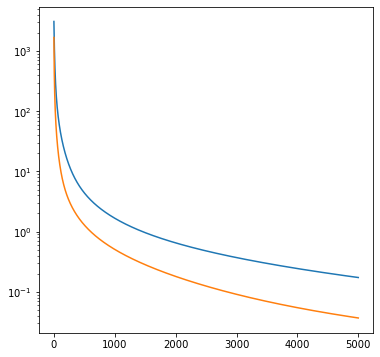

In [190]:
plt.semilogy(loss_gd)
plt.semilogy(loss_o)

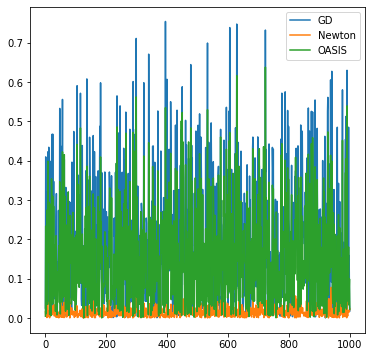

In [194]:
plt.plot(jnp.abs(x-x_gd))
plt.plot(jnp.abs(x-x_n))
plt.plot(jnp.abs(x-x_o))
plt.legend(["GD", "Newton", "OASIS"])